In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)
sns.set_style('ticks')

In [2]:
def plot_ride_count(data, month, filename="file", title=""):
    data = data.loc[data['month'] ==month]
    weekend = data.loc[data['isWeekend'] == True]
    weekday = data.loc[~data['isWeekend'] == True]
    holiday = data.loc[data['isHoliday'] == True]
    fig = plt.figure(figsize=(13,4))
    ax1 = fig.add_subplot(111)
    ax1.bar('day', 'count',data = weekend, label='Weekend' , color='coral')
    ax1.bar('day', 'count',data = weekday, label='Week Day', color='royalblue')
    if len(holiday)!=0:
        ax1.bar('day', 'count',data = holiday, label='Public Holiday', color='chartreuse')
    ax1.legend()
    ax1.set_axisbelow(True)
    ax1.set_xticks(data['day'])
    ax1.grid()
    plt.title(title)
    if save:
        plt.savefig(path+filename+".jpg")
    
    plt.show()

#### Defining switches and control variables.

In [3]:
data_load = True
save = True
export = True
path = "graphs/"

#### Load Data

In [4]:
if data_load:
    data_march = pd.read_csv("201703/201703-citibike-tripdata.csv")
    data_july = pd.read_csv("201707/201707-citibike-tripdata.csv")
    data_oct = pd.read_csv("201710/201710-citibike-tripdata.csv")
    data_dec = pd.read_csv("201712/201712-citibike-tripdata.csv")
    data_march.columns=data_oct.columns
    print(data_march.shape, data_july.shape, data_oct.shape, data_dec.shape)
    data = pd.concat([data_march, data_july, data_oct, data_dec])

(727665, 15) (1735599, 15) (1897592, 15) (889967, 15)


#### Extracting Hour, Minute, Day, Weekday, Month and Year from the ride data. 

In [5]:
data['hour'] = pd.to_datetime(data['starttime']).dt.hour
data['min'] = pd.to_datetime(data['starttime']).dt.minute
data['day'] = pd.to_datetime(data['starttime']).dt.day
data['weekday'] = pd.to_datetime(data['starttime']).dt.weekday
data['month'] = pd.to_datetime(data['starttime']).dt.month
data['year'] = pd.to_datetime(data['starttime']).dt.year

#### Getting daily total number of rides regarding usertype

In [6]:
ride_count = data.groupby(by=['day', 'usertype', 'weekday', 'month','year']).size().reset_index(name='count')

##### We have 4 months with 31 days in month each. Across 2 usertyes, we should have  (31 x 4 x 2)=248 rows in this aggregation. We have only 242 data points. We must have missing data.

In [7]:
print(len(ride_count))

242


##### We should have 62 rows, 31 for customer and 31 for subscriber.  We have missing data for 3 days. 

In [8]:
print(len(ride_count.loc[ride_count['month']==3]))

56


#### We have missing data for 14th, 15th and 16th March, 2017.

In [9]:
ride_count.loc[ride_count['month']==3]['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64)

#### Fill the missing data with 0 ride counts for these 3 days. 

In [10]:
march_missing = pd.DataFrame({
    'day': [14,14,15,15,16,16],
    'usertype':['Customer', 'Subscriber'] * 3,
    'weekday':[1,1,2,2,3,3],
    'month':[3]*6,
    'year':[2017]*6,
    'count':[0]*6
})

In [11]:
ride_count = pd.concat([ride_count,march_missing]).sort_values(by=['day', 'month', 'usertype']).reset_index(drop=True)

In [12]:
print(len(ride_count))

248


#### Extracting a feature 'isWeekend' to denote if the given day is a weekend or not

In [13]:
ride_count['isWeekend'] = False
ride_count.loc[ride_count['weekday'].isin([5,6]), 'isWeekend'] = True #weekday 5,6 denote saturday and sunday.

In [14]:
display(ride_count.head(10))

,count,day,month,usertype,weekday,year,isWeekend
0,1027,1,3,Customer,2,2017,False
1,39374,1,3,Subscriber,2,2017,False
2,9344,1,7,Customer,5,2017,True
3,27393,1,7,Subscriber,5,2017,True
4,10477,1,10,Customer,6,2017,True
5,45028,1,10,Subscriber,6,2017,True
6,2181,1,12,Customer,4,2017,False
7,48527,1,12,Subscriber,4,2017,False
8,1006,2,3,Customer,3,2017,False
9,34511,2,3,Subscriber,3,2017,False


#### Defining public holidays.

In [15]:
ride_count['isHoliday'] = False

In [16]:
public_holiday=pd.DataFrame({
    'day': [4,9,25],
    'month': [7,10,12]
})

In [17]:
public_holiday

,day,month
0,4,7
1,9,10
2,25,12


In [18]:
mask = ride_count.reset_index().merge(public_holiday)['index']

In [19]:
ride_count.loc[mask, 'isHoliday'] = True

### Plotting Subscribers & Customers for the month of July

#### We can see that there are more number of Subscribers during weekdays than during weekends.

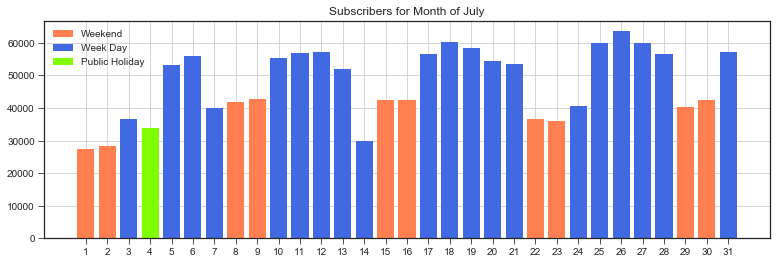

In [20]:
title = "Subscribers for Month of July"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Subscriber'], month=7, filename = "ride_count_july_sub", title=title)

#### We can see that there are more number of Customers during weekends than during weekdays. A complete reverse trend than one observed for Subscribers. 4th of July is a weekday but has a higher Customer riders because it is a national holiday. 

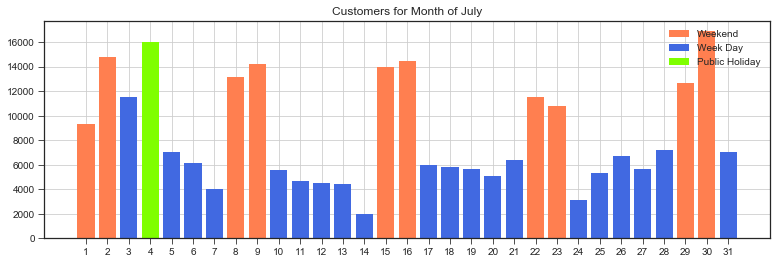

In [21]:
title = "Customers for Month of July"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Customer'], month=7, filename = "ride_count_july_cust", title=title)

### Plotting Subscribers and Customers for the month of December.

#### Similar trend in terms of weekdays and weekdays for the month of december. There are high number of Subscribers on weekdays than on weekends while there are hih number of Customers on weekends compared to weekdays. However, The number of riders for both the usertyes are lower as the month progresses. In particular the number of customer rides are significantly lower. 

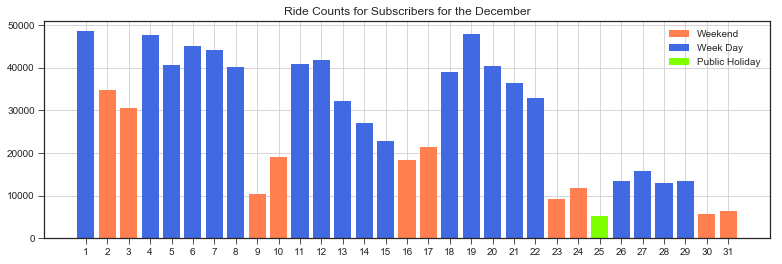

In [22]:
title="Ride Counts for Subscribers for the December"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Subscriber'], month=12, filename="ride_count_dec_sub", title=title)

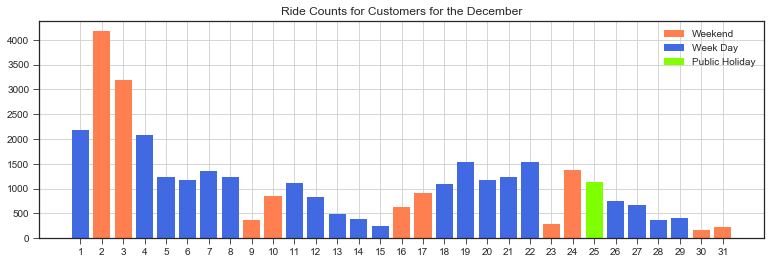

In [23]:
title="Ride Counts for Customers for the December"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Customer'], month=12, filename="ride_count_dec_cust", title=title)

### Plotting Subscribers and Customers for the month of March.

#### No ride counts across both the usertypes for 14th, 15th and 16th March.

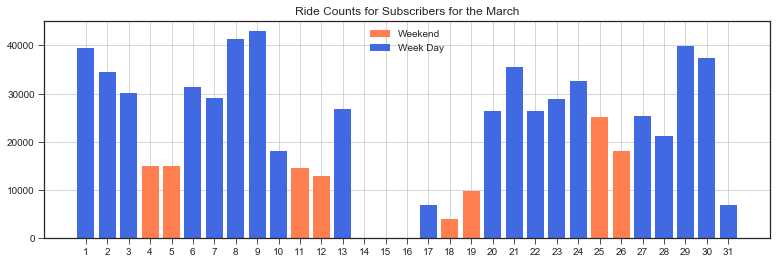

In [24]:
title="Ride Counts for Subscribers for the March"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Subscriber'], month=3, filename="ride_count_mar_sub", title=title)

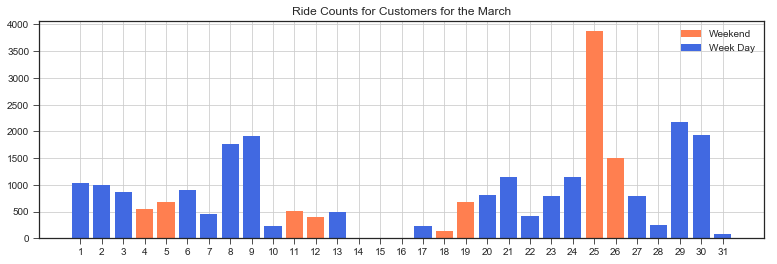

In [25]:
title="Ride Counts for Customers for the March"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Customer'], month=3, filename="ride_count_mar_cust", title=title)

### Plotting Subscribers and Customers for the month of October.

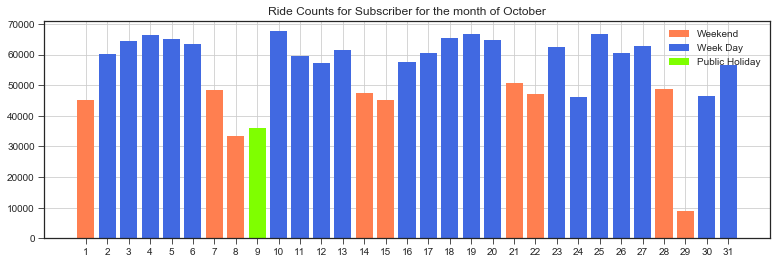

In [26]:
title = "Ride Counts for Subscriber for the month of October"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Subscriber'], month=10, filename="ride_count_oct_cust", title=title)

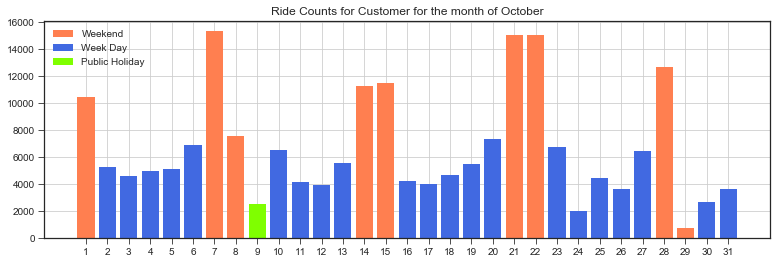

In [27]:
title = "Ride Counts for Customer for the month of October"
plot_ride_count(ride_count.loc[ride_count['usertype'] == 'Customer'], month=10, filename="ride_count_oct_sub", title=title)

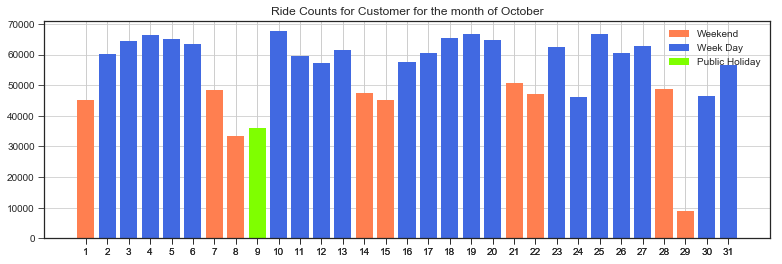

In [28]:
plot_ride_count(ride_count, month=10, filename="ride_count_oct_sub", title=title)

### Rush Hours

In [29]:
rush_hour = data.groupby(by=['hour', 'usertype']).size().reset_index(name='count')

#### There are two peak hours. 8-9 AM in the morning and 5-6 PM in the evening for Subscribers.

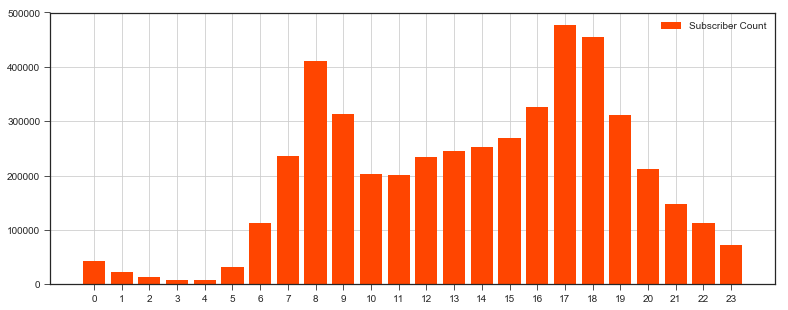

In [30]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.bar('hour', 'count', data=rush_hour.loc[rush_hour['usertype'] == 'Subscriber'], color='orangered', label='Subscriber Count')
ax.set_xticks(rush_hour[rush_hour['usertype'] == 'Subscriber']['hour'])
ax.grid()
ax.legend()
if save:
    plt.savefig(path+"rush_hour_sub.jpg")
plt.show()

#### Most of the Customer rides are noticed around 10 AM to 7 PM.

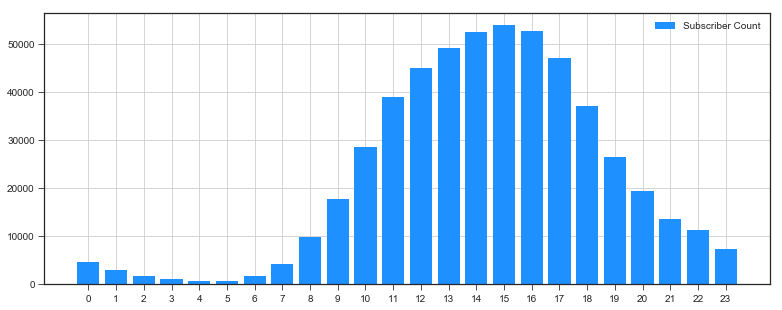

In [31]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.bar('hour', 'count', data=rush_hour.loc[rush_hour['usertype'] == 'Customer'], color='dodgerblue', label='Subscriber Count')
ax.set_xticks(rush_hour[rush_hour['usertype'] == 'Customer']['hour'])
ax.grid()
ax.legend()
if save:
    plt.savefig(path+"rush_hour_cust.jpg")
plt.show()

### Station Analysis

#### Rides that have distinctive stations may yeild information about popular paths in the city.

In [32]:
data_station = data.loc[data['start station id'] != data['end station id']]
customer_stations = data_station.loc[data_station['usertype'] == 'Customer']
subscriber_stations = data_station.loc[data_station['usertype'] == 'Subscriber']

#### Popular stations amongst Customers. Seems like the stations around Central Park. 

In [33]:
ride_path_count_cust = customer_stations.groupby(by=['start station id','start station name','start station longitude','start station latitude','end station id','end station name','end station longitude','end station latitude', 'month']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
display(ride_path_count_cust.head(10))

,start station id,start station name,start station longitude,start station latitude,end station id,end station name,end station longitude,end station latitude,month,count
85658,2006,Central Park S & 6 Ave,-73.976342,40.765909,3282,5 Ave & E 88 St,-73.959390,40.783070,7,788
85659,2006,Central Park S & 6 Ave,-73.976342,40.765909,3282,5 Ave & E 88 St,-73.959390,40.783070,10,674
108905,3182,Yankee Ferry Terminal,-74.016966,40.686931,3254,Soissons Landing,-74.014866,40.692317,7,655
112290,3254,Soissons Landing,-74.014866,40.692317,3182,Yankee Ferry Terminal,-74.016966,40.686931,7,615
85752,2006,Central Park S & 6 Ave,-73.976342,40.765909,3374,Central Park North & Adam Clayton Powell Blvd,-73.955613,40.799484,7,488
17591,281,Grand Army Plaza & Central Park S,-73.973715,40.764397,3282,5 Ave & E 88 St,-73.959390,40.783070,7,480
74749,514,12 Ave & W 40 St,-74.002777,40.760875,426,West St & Chambers St,-74.013221,40.717548,7,470
40132,387,Centre St & Chambers St,-74.004607,40.712733,232,Cadman Plaza E & Tillary St,-73.990149,40.695977,7,462
75052,514,12 Ave & W 40 St,-74.002777,40.760875,3256,Pier 40 - Hudson River Park,-74.011296,40.727714,7,458
85514,2006,Central Park S & 6 Ave,-73.976342,40.765909,3137,5 Ave & E 73 St,-73.966853,40.772828,7,432


#### Popular stations amongst Customers. We can see that among top 10, E 7 St & Avenue A, Cooper Square & Astor Pl, Pershing Square North are popular stations.

In [34]:
ride_path_count_sub = subscriber_stations.groupby(by=['start station id','start station name','start station longitude','start station latitude','end station id','end station name','end station longitude','end station latitude', 'month']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
display(ride_path_count_sub.head(10))

,start station id,start station name,start station longitude,start station latitude,end station id,end station name,end station longitude,end station latitude,month,count
181889,432,E 7 St & Avenue A,-73.983799,40.726218,3263,Cooper Square & Astor Pl,-73.990753,40.729515,10,802
181892,432,E 7 St & Avenue A,-73.983799,40.726218,3263,Cooper Square & E 7 St,-73.990868,40.729236,7,732
181890,432,E 7 St & Avenue A,-73.983799,40.726218,3263,Cooper Square & Astor Pl,-73.990753,40.729515,12,569
210570,460,S 4 St & Wythe Ave,-73.965903,40.712859,3093,N 6 St & Bedford Ave,-73.958509,40.717452,10,535
401034,3254,Soissons Landing,-74.014866,40.692317,3182,Yankee Ferry Terminal,-74.016966,40.686931,7,528
270044,519,Pershing Square North,-73.977706,40.751873,492,W 33 St & 7 Ave,-73.990931,40.750200,3,519
270042,519,Pershing Square North,-73.977706,40.751873,491,E 24 St & Park Ave S,-73.986022,40.740964,10,506
445021,3351,E 102 St & 1 Ave,-73.941648,40.786995,3318,2 Ave & E 96 St,-73.947167,40.783964,7,494
387511,3182,Yankee Ferry Terminal,-74.016966,40.686931,3254,Soissons Landing,-74.014866,40.692317,7,484
407313,3263,Cooper Square & Astor Pl,-73.990753,40.729515,432,E 7 St & Avenue A,-73.983799,40.726218,10,475


#### Extracting Subscriber and Customer count and making it a feature.

In [35]:
ride_count.head()

,count,day,month,usertype,weekday,year,isWeekend,isHoliday
0,1027,1,3,Customer,2,2017,False,False
1,39374,1,3,Subscriber,2,2017,False,False
2,9344,1,7,Customer,5,2017,True,False
3,27393,1,7,Subscriber,5,2017,True,False
4,10477,1,10,Customer,6,2017,True,False


In [36]:
customer_count = ride_count.loc[ride_count['usertype']=="Customer"]['count']
subscriber_count = ride_count.loc[ride_count['usertype']=="Subscriber"]['count']

In [37]:
ride_count2 = ride_count.drop(['count', 'usertype'], axis=1).drop_duplicates()

In [38]:
ride_count2['customer'] = list(customer_count)
ride_count2['subscriber'] = list(subscriber_count)

In [39]:
if export:
    ride_count2.to_csv("data/ride_count.csv", index=False)
    ride_path_count_cust.to_csv("data/ride_path_count_cust.csv", index=False)
    ride_path_count_sub.to_csv("data/ride_path_count_sub.csv", index=False)
    rush_hour.to_csv("data/rush_hour.csv", index=False)